# 📊 Round Robin Benchmark Analysis

This notebook loads the latest benchmark results from:

`src/ai/statistics/round_robin_results/*.csv`

and computes winrates, matchup charts, damage statistics, and NEAT-style metrics.

In [57]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Notebook working directory
CWD = Path().resolve()

# Walk upward until we find the project root (folder containing `src/`)
while CWD != CWD.root and not (CWD / "src").exists():
    CWD = CWD.parent

PROJECT_ROOT = CWD
print("Detected project root:", PROJECT_ROOT)

RESULTS_DIR = PROJECT_ROOT / "src/ai/statistics/round_robin_results"
print("Using results dir:", RESULTS_DIR)

csv_files = sorted(RESULTS_DIR.glob("round_robin_*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {RESULTS_DIR}")

latest_csv = csv_files[-1]
print("📄 Loading:", latest_csv)

df = pd.read_csv(latest_csv)
df.head()

Detected project root: /home/cillard/projects/Game
Using results dir: /home/cillard/projects/Game/src/ai/statistics/round_robin_results
📄 Loading: /home/cillard/projects/Game/src/ai/statistics/round_robin_results/round_robin_20251209_203406.csv


,agentA,agentB,winner,turns,avg_turn_time_A,avg_turn_time_B,initial_unit_count_team1,initial_unit_count_team2,alive1,alive2,max_hp_team1,max_hp_team2,hp1,hp2
0,NEATAgent,MCTS_fast,1.0,27,0.077989,0.554451,4,4,4,0,415,430,128,0
1,NEATAgent,MCTS_default,1.0,18,0.053695,1.341585,4,4,3,0,370,325,204,0
2,NEATAgent,Minimax_default,NaN,30,0.029429,1.044460,4,4,1,1,325,370,34,32
3,MCTS_default,NEATAgent,NaN,30,1.444448,0.028449,4,3,4,1,420,270,88,19
4,NEATAgent,MCTS_deep,NaN,30,0.040439,2.803845,4,4,1,3,400,365,3,83


Agent Timing Info

In [58]:
# Convert match rows into per-agent timing rows
rows = []

for _, r in df.iterrows():
    rows.append(
        {
            "agent": r["agentA"],
            "avg_turn_time": r["avg_turn_time_A"],
        }
    )
    rows.append(
        {
            "agent": r["agentB"],
            "avg_turn_time": r["avg_turn_time_B"],
        }
    )

df_agents = pd.DataFrame(rows)
df_agents

,agent,avg_turn_time
0,NEATAgent,0.077989
1,MCTS_fast,0.554451
2,NEATAgent,0.053695
3,MCTS_default,1.341585
4,NEATAgent,0.029429
...,...,...
79,Minimax_default,1.663631
80,Minimax_wide,3.863374
81,Minimax_deep,3.553589
82,Minimax_wide,3.207213


In [59]:
agent_time = (
    df_agents.groupby("agent")["avg_turn_time"]
    .mean()
    .sort_values()
    .to_frame("mean_turn_time")
)

agent_time

,mean_turn_time
agent,
NEATAgent,0.060766
MCTS_fast,0.560399
MCTS_default,1.475572
Minimax_default,1.525625
MCTS_deep,2.977214
Minimax_wide,3.291327
Minimax_deep,4.321060


/tmp/ipykernel_11341/298005037.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


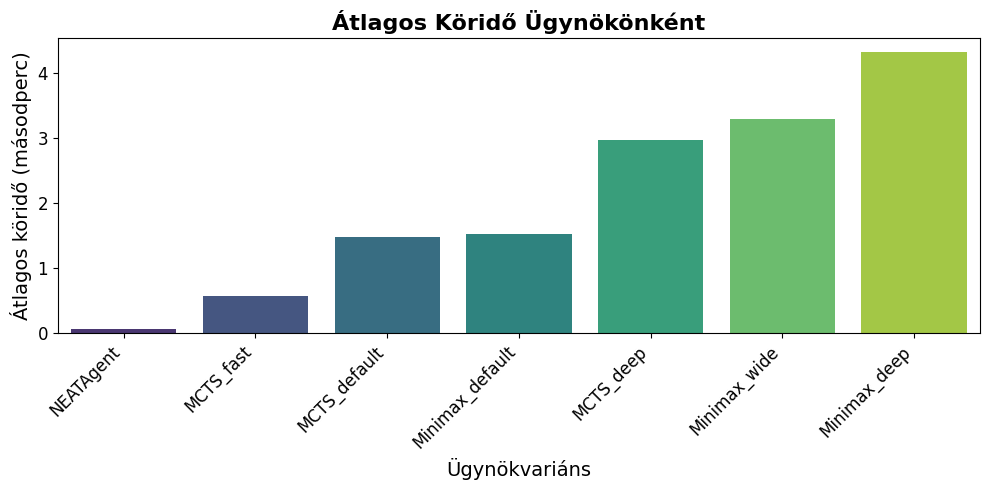

In [60]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=agent_time.reset_index(), x="agent", y="mean_turn_time", palette="viridis"
)

plt.title("Átlagos Köridő Ügynökönként", fontsize=16, fontweight="bold")
plt.ylabel("Átlagos köridő (másodperc)", fontsize=14)
plt.xlabel("Ügynökvariáns", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Does deeper minimax explode turn time?

In [61]:
minimax_rows = agent_time[agent_time.index.str.contains("Minimax")]

print("🧠 Minimax Compute Cost Comparison:")
minimax_rows

🧠 Minimax Compute Cost Comparison:


,mean_turn_time
agent,
Minimax_default,1.525625
Minimax_wide,3.291327
Minimax_deep,4.321060


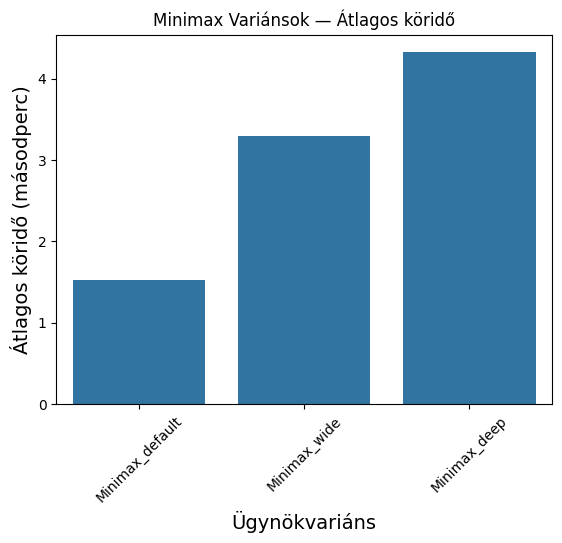

In [62]:
# Extract rollout_turns from preset name if you encode it there, or join
# from preset file
sns.barplot(x=minimax_rows.index, y=minimax_rows["mean_turn_time"])
plt.xticks(rotation=45)
plt.ylabel("Átlagos köridő (másodperc)", fontsize=14)
plt.xlabel("Ügynökvariáns", fontsize=14)
plt.title("Minimax Variánsok — Átlagos köridő")
plt.show()

Is MCTS rollout parameter affecting compute cost?

In [63]:
mcts_rows = agent_time[agent_time.index.str.contains("MCTS")]

print("🌲 MCTS Compute Cost Comparison:")
mcts_rows

🌲 MCTS Compute Cost Comparison:


,mean_turn_time
agent,
MCTS_fast,0.560399
MCTS_default,1.475572
MCTS_deep,2.977214


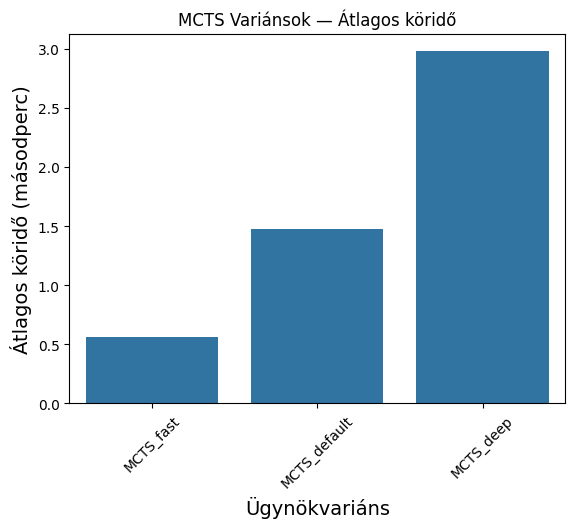

In [64]:
# Extract rollout_turns from preset name if you encode it there, or join
# from preset file
sns.barplot(x=mcts_rows.index, y=mcts_rows["mean_turn_time"])
plt.xticks(rotation=45)
plt.ylabel("Átlagos köridő (másodperc)", fontsize=14)
plt.xlabel("Ügynökvariáns", fontsize=14)
plt.title("MCTS Variánsok — Átlagos köridő")
plt.show()

## 🧮 Winrate Summary

In [65]:
agents = sorted(set(df["agentA"]) | set(df["agentB"]))

# Collect stats
win_stats = {a: {"wins": 0, "games": 0, "time_sum": 0.0} for a in agents}

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]

    # --- Agent A ---
    win_stats[A]["games"] += 1
    win_stats[A]["time_sum"] += row["avg_turn_time_A"]
    if winner == 1:
        win_stats[A]["wins"] += 1

    # --- Agent B ---
    win_stats[B]["games"] += 1
    win_stats[B]["time_sum"] += row["avg_turn_time_B"]
    if winner == 2:
        win_stats[B]["wins"] += 1

# Build summary table
summary = pd.DataFrame(
    [
        {
            "agent": agent,
            "winrate": win_stats[agent]["wins"] / win_stats[agent]["games"],
            "avg_turn_time": win_stats[agent]["time_sum"] / win_stats[agent]["games"],
        }
        for agent in agents
    ]
).set_index("agent")

summary

,winrate,avg_turn_time
agent,,
MCTS_deep,0.083333,2.977214
MCTS_default,0.000000,1.475572
MCTS_fast,0.083333,0.560399
Minimax_deep,0.250000,4.321060
Minimax_default,0.333333,1.525625
Minimax_wide,0.416667,3.291327
NEATAgent,0.416667,0.060766


## 🔥 Head-to-Head Winrate Matrix

In [66]:
matrix = pd.DataFrame(0.0, index=agents, columns=agents)

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]
    if winner == 1:
        matrix.loc[A, B] += 1
    elif winner == 2:
        matrix.loc[B, A] += 1

games_matrix = df.groupby(["agentA", "agentB"]).size().unstack(fill_value=0)

winrate_matrix = matrix.div(games_matrix + games_matrix.T, fill_value=0)
winrate_matrix

,MCTS_deep,MCTS_default,MCTS_fast,Minimax_deep,Minimax_default,Minimax_wide,NEATAgent
MCTS_deep,NaN,0.0,0.0,0.0,0.5,0.0,0.0
MCTS_default,0.0,NaN,0.0,0.0,0.0,0.0,0.0
MCTS_fast,0.0,0.0,NaN,0.0,0.0,0.5,0.0
Minimax_deep,0.5,0.5,0.5,NaN,0.0,0.0,0.0
Minimax_default,0.0,0.5,0.5,0.5,NaN,0.5,0.0
Minimax_wide,0.5,0.5,0.0,1.0,0.0,NaN,0.5
NEATAgent,0.5,0.5,1.0,0.0,0.5,0.0,NaN


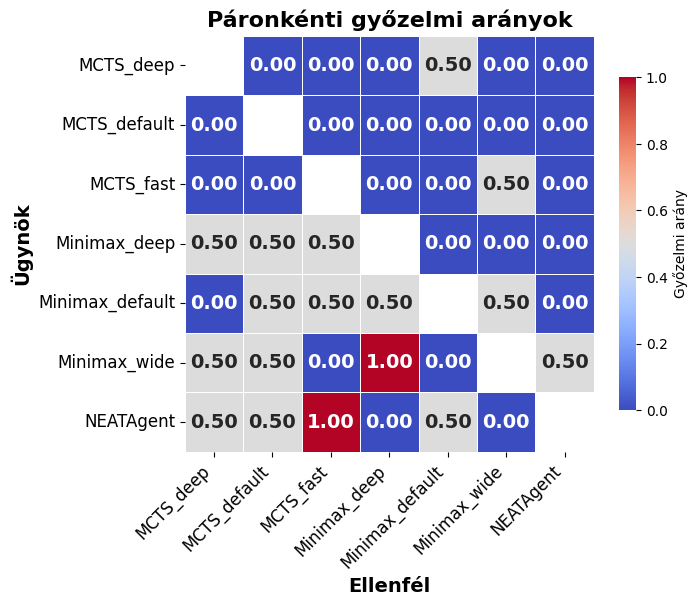

In [67]:
plt.figure(figsize=(7, 6))  # smaller figure → smaller grid cells

ax = sns.heatmap(
    winrate_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    fmt=".2f",
    linewidths=0.7,
    annot_kws={"size": 14, "fontweight": "bold"},  # BIGGER numbers
    cbar_kws={"label": "Győzelmi arány", "shrink": 0.8},
)

# Axis labels
ax.set_xlabel("Ellenfél", fontsize=14, fontweight="bold")
ax.set_ylabel("Ügynök", fontsize=14, fontweight="bold")

# Title
ax.set_title("Páronkénti győzelmi arányok", fontsize=16, fontweight="bold")

# Tick labels
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout(pad=0.5)  # reduce padding → grid fills more space
plt.show()

## Turn Time Winrate Correlation

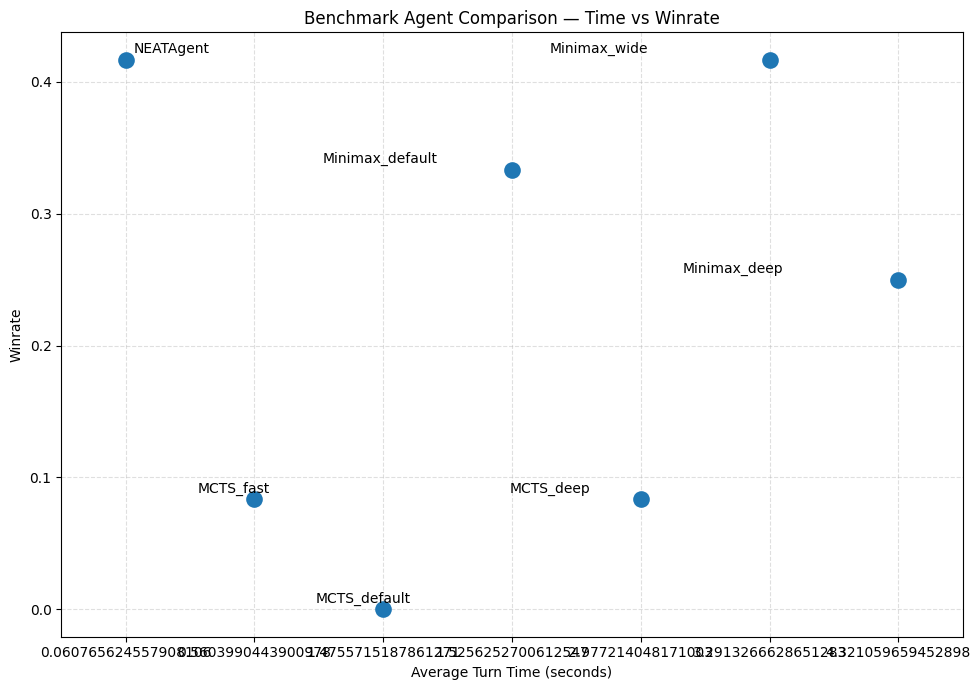

In [68]:
plt.figure(figsize=(10, 7))

sns.stripplot(
    data=summary.reset_index(),
    x="avg_turn_time",
    y="winrate",
    jitter=0.25,
    size=12,
)

for agent, row in summary.iterrows():
    plt.text(
        row["avg_turn_time"] + 0.002,  # slight offset
        row["winrate"] + 0.005,
        str(agent),
        fontsize=10,
        ha="left",
    )

plt.title("Benchmark Agent Comparison — Time vs Winrate")
plt.xlabel("Average Turn Time (seconds)")
plt.ylabel("Winrate")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## ⛑️ Survival Ratio

In [69]:
# Compute alive ratio per agent from stats
alive_rows = []

for _, r in df.iterrows():
    alive_rows.append(
        {
            "agent": r["agentA"],
            "alive_ratio": r["alive1"] / max(1, r["initial_unit_count_team1"]),
        }
    )
    alive_rows.append(
        {
            "agent": r["agentB"],
            "alive_ratio": r["alive2"] / max(1, r["initial_unit_count_team2"]),
        }
    )

df_alive = pd.DataFrame(alive_rows)
agent_alive = df_alive.groupby("agent")["alive_ratio"].mean().to_frame("alive_ratio")

agent_alive

,alive_ratio
agent,
MCTS_deep,0.470833
MCTS_default,0.404167
MCTS_fast,0.333333
Minimax_deep,0.466667
Minimax_default,0.462500
Minimax_wide,0.625000
NEATAgent,0.506944
